In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler

In [2]:
import survivors.datasets as ds
from survivors.ensemble import BoostingCRAID

axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

In [17]:
class BoostingVisualize(BoostingCRAID):
    def update_weight(self, index, wei_i):
        super().update_weight(index, wei_i)
        self.visualize_weights(index)
    
    def visualize_weights(self, train_index):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        oob_index = self.X_train.loc[self.X_train.index.difference(train_index),:]['ind_start']
        ax.set_title(f"Sample probability after {len(self.bettas)} Tree", **axis_font)
        ax.scatter(oob_index, self.weights[oob_index], 10, label = "Out-of-back")
        ax.scatter(train_index, self.weights[train_index], 10, label = "Train")
        ax.set_xlabel("Observation number", **axis_font)
        ax.legend()

[0.168  0.1564 0.1551 0.1547 0.1513 0.1478 0.1438 0.143  0.1414 0.1422]
fitted: 9 models.


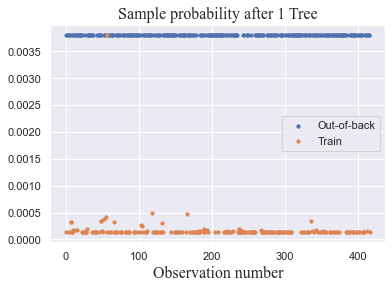

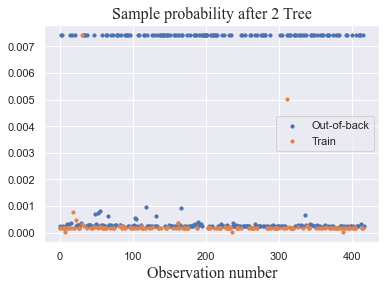

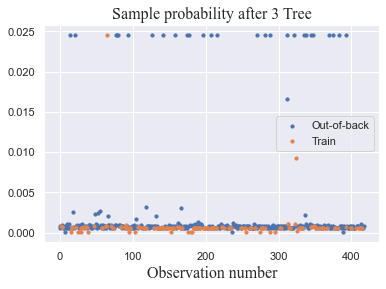

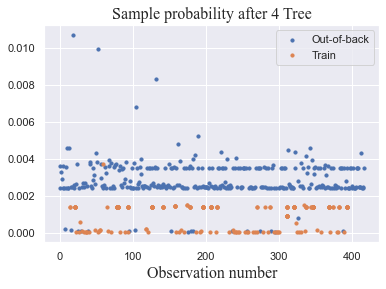

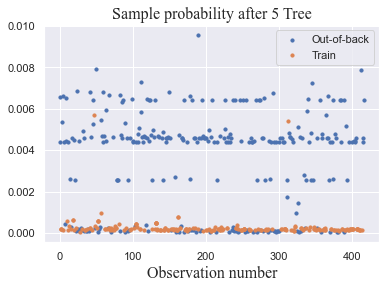

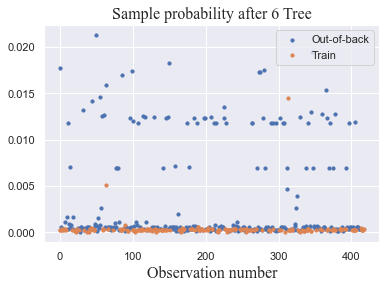

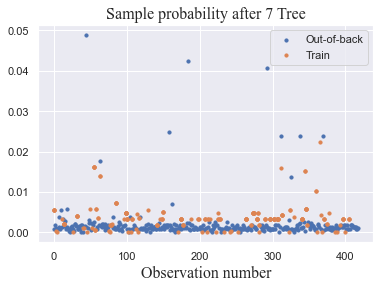

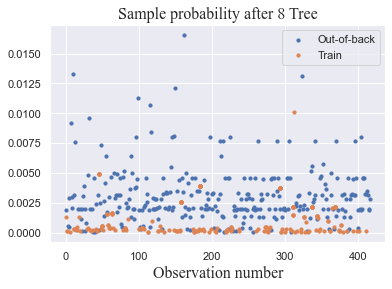

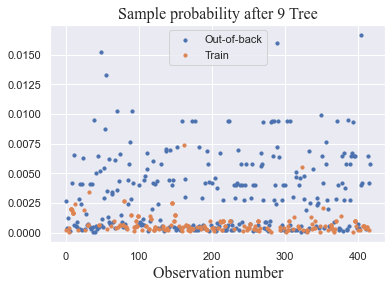

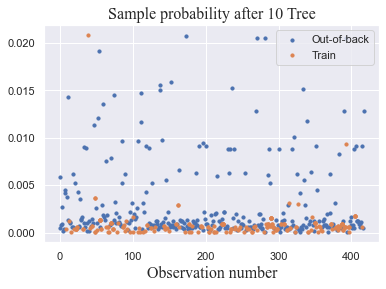

In [22]:
import survivors.datasets as ds
from survivors.ensemble import BoostingCRAID
from sklearn.metrics import roc_auc_score
import cProfile
import pstats

param = {'aggreg_func': 'wei', 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'],
        'criterion': 'weights', 'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 'sqrt',
        'min_samples_leaf': 10, 'mode_wei': 'square', 'n_estimators': 10, 'size_sample': 0.5, 
        "leaf_model": "base_fast", "all_weight": False}

X, y, features, categ, sch_nan = ds.load_pbc_dataset()

bst = BoostingVisualize(**param)
bst.fit(X, y)

[0.168  0.1591 0.1688 0.1648 0.1696 0.1651 0.165  0.1655 0.1646 0.1645]
fitted: 2 models.


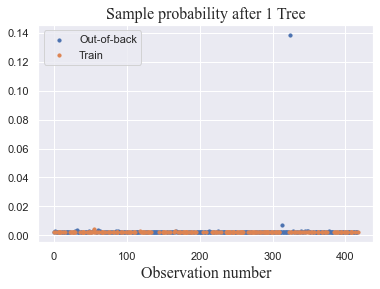

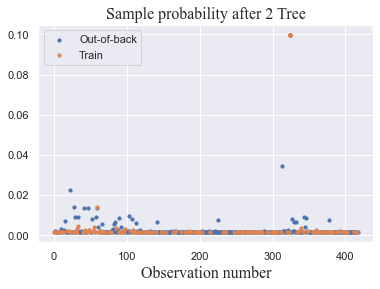

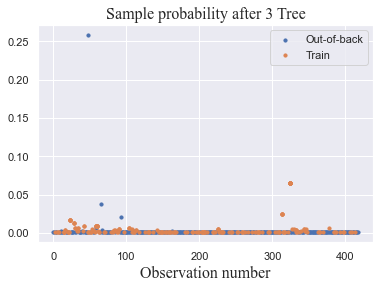

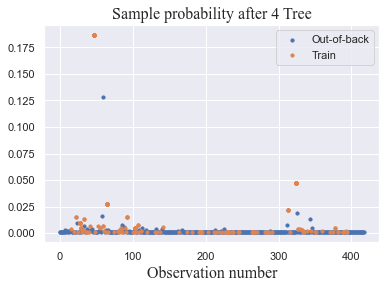

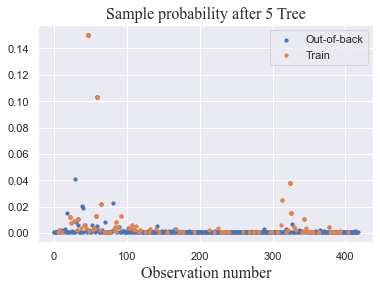

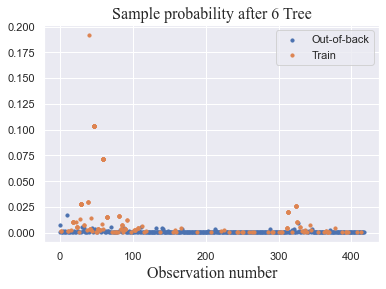

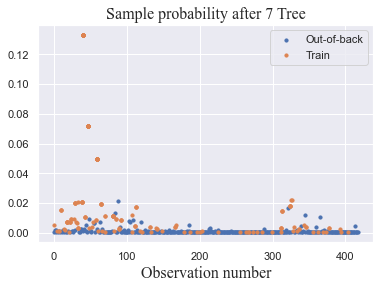

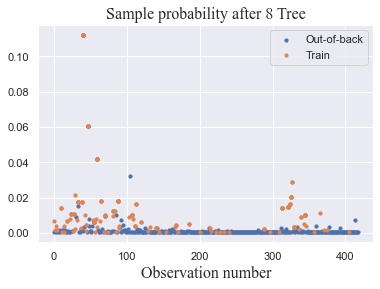

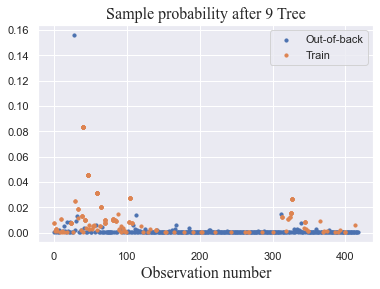

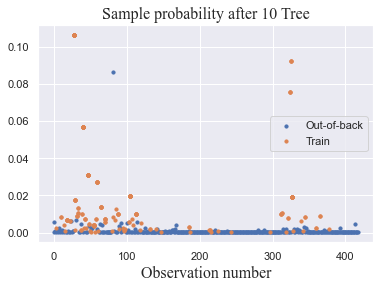

In [23]:
param = {'aggreg_func': 'wei', 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'],
        'criterion': 'weights', 'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 'sqrt',
        'min_samples_leaf': 10, 'mode_wei': 'square', 'n_estimators': 10, 'size_sample': 0.5, 
        "leaf_model": "base_fast", "all_weight": True}

bst = BoostingVisualize(**param)
bst.fit(X, y)

In [55]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter

X_ = X.copy()
X_[cnt.TIME_NAME] = y[cnt.TIME_NAME]
X_[cnt.CENS_NAME] = y[cnt.CENS_NAME]
bins = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

X_ = X_.fillna(0).replace(np.nan, 0)
weib = WeibullAFTFitter()
weib.fit(X_, cnt.TIME_NAME, cnt.CENS_NAME)

<lifelines.WeibullAFTFitter: fitted with 418 total observations, 257 right-censored observations>

In [60]:
weib.predict_survival_function(X_, times=bins).to_numpy().T

array([[9.51029692e-01, 9.49294707e-01, 9.47542900e-01, ...,
        1.75666930e-21, 1.72720899e-21, 1.69823945e-21],
       [9.99390320e-01, 9.99368155e-01, 9.99345734e-01, ...,
        5.59628467e-01, 5.59513516e-01, 5.59398575e-01],
       [9.94289702e-01, 9.94082651e-01, 9.93873252e-01, ...,
        4.29307483e-03, 4.28480159e-03, 4.27654334e-03],
       ...,
       [9.99091286e-01, 9.99058254e-01, 9.99024842e-01, ...,
        4.20914594e-01, 4.20785716e-01, 4.20656864e-01],
       [9.99280451e-01, 9.99254293e-01, 9.99227834e-01, ...,
        5.04026083e-01, 5.03903891e-01, 5.03781715e-01],
       [9.98827436e-01, 9.98784819e-01, 9.98741712e-01, ...,
        3.27350162e-01, 3.27220819e-01, 3.27091512e-01]])

In [4]:
X, y, features, categ, sch_nan = ds.load_covid_dataset("C:\\Users\\vasiliev\\Desktop\\PycharmProjects\\dev-survivors\\survivors\\datasets\\data\\COVID")

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\covid.py:205: DtypeWarning: Columns (12,33,36,37,46,47,48,49,103,111,112,147,148,247,248,267,268,275,276,283,284,295,296,307,308) have mixed types. Specify dtype option on import or set low_memory=False.
  cyto = pd.read_csv(join(dir_env, "cyto_with_schemes.csv"))


Categ-contin var: has_odyshka_ili_zatrudnennoe_dyhanie
Categ-contin var: has_oschussh_zalozhen_v_grudnoi_kletke
Categ-contin var: has_slabost_ili_lomota
Categ-contin var: Пол
Categ-contin var: PCR_N
Categ-contin var: has_kashel
Categ-contin var: kashel_type
Categorical var: resultat_KT 6


In [18]:
from survivors.ensemble import BoostingCRAID

param = {
    "size_sample": 0.5,
    "n_estimators": 20,
    "ens_metric_name": "ibs",  # "conc",
    "depth": 10,
    "mode_wei": 'exp',
    "criterion": "peto",
    "min_samples_leaf": 100,
    "max_features": 0.3,
    "aggreg_func": 'mean',
    "leaf_model": "base_fast",
    "all_weight": True,  # , False],
    "n_jobs": 5
}


bst = BoostingCRAID(**param)
bst.fit(X[:30000], y[:30000])

[0.1727 0.1622 0.1598 0.1626 0.1632 0.1665 0.1683 0.1688 0.1709 0.1718
 0.1731 0.1749 0.1763 0.1781 0.1794 0.1801 0.181  0.1818 0.1828 0.1836]
fitted: 3 models.


In [56]:
from sklearn.model_selection import StratifiedKFold

def prepare_sample(X, y, train_index, test_index):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    bins = cnt.get_bins(time=y_train[cnt.TIME_NAME], cens=y_train[cnt.CENS_NAME])
    y_train[cnt.TIME_NAME] = np.clip(y_train[cnt.TIME_NAME], bins.min() - 1, bins.max() + 1)
    y_test[cnt.TIME_NAME] = np.clip(y_test[cnt.TIME_NAME], bins.min(), bins.max())
    return X_train, y_train, X_test, y_test, bins

skf = StratifiedKFold(n_splits=5)
train_index = np.array([], dtype=int)
for train_index_, test_index_ in skf.split(X, y[cnt.CENS_NAME]):
    if train_index.shape[0] > 0:
        X_train, y_train, X_test, y_test, bins = prepare_sample(X, y, train_index, test_index_)
        break
    train_index = np.hstack([train_index, test_index_])

(array([13617., 15210.,  2448.,   688.,   231.,    65.,    70.,    64.,
           54.,   137.]),
 array([  0. ,  21.5,  43. ,  64.5,  86. , 107.5, 129. , 150.5, 172. ,
        193.5, 215. ]),
 <BarContainer object of 10 artists>)

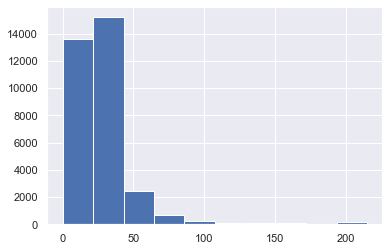

In [48]:
plt.hist(y_test["time"].astype(int))

In [52]:
bst = BoostingCRAID(**param)
bst.fit(X_train, y_train)

[0.1818 0.1677 0.1664 0.1655 0.1675 0.1693 0.1709 0.1728 0.1742 0.176
 0.1779 0.1798 0.1813 0.1822 0.1834 0.1844 0.1857 0.1865 0.1877 0.1885]
fitted: 4 models.


In [53]:
from lifelines.utils import concordance_index

pred_time = bst.predict(X_test, target=cnt.TIME_NAME)
print("CI:", concordance_index(y_test[cnt.TIME_NAME], pred_time))
print("CI_CENS:", concordance_index(y_test[cnt.TIME_NAME], pred_time, y_test[cnt.CENS_NAME]))

CI: 0.4867096722261475
CI_CENS: 0.29392741016451934


In [71]:
y

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [57]:
np.bincount(y_train["cens"]), np.bincount(y_test["cens"])

(array([27433,  5151], dtype=int64), array([27433,  5151], dtype=int64))

In [74]:
np.bincount(y["time"].astype(int))

array([1127, 2449, 2423, 1937, 1980, 2211, 2451, 2703, 2764, 2814, 2665,
       2749, 2664, 2899, 3082, 3027, 3091, 3453, 4166, 5153, 6033, 6544,
       6440, 6613, 6569, 6293, 5983, 5669, 5042, 4454, 3940, 3544, 3090,
       2667, 2470, 2255, 2009, 1724, 1629, 1548, 1428, 1279, 1206, 1087,
        958,  923,  821,  822,  703,  714,  690,  619,  526,  537,  487,
        458,  466,  381,  378,  321,  302,  298,  292,  293,  262,  260,
        243,  236,  196,  213,  189,  187,  175,  161,  148,  162,  142,
        128,  136,  128,   99,  102,   91,   94,  106,   87,   59,   75,
         86,   71,   70,   57,   65,   47,   60,   50,   64,   58,   50,
         53,   41,   40,   38,   38,   27,   30,   23,   29,   19,   14,
         21,   31,   22,   28,   19,    9,   21,   17,   16,   23,   16,
         23,   21,   15,   15,   14,   15,   21,   20,   22,   19,   18,
         17,   18,   14,   25,   12,   12,   18,    8,   13,   10,   18,
         16,   15,   20,   18,   18,   12,   11,   

In [61]:
np.bincount(y_train["time"].astype(int)), np.bincount(y_test["time"].astype(int))

(array([ 213,  483,  499,  392,  385,  456,  464,  523,  570,  577,  539,
         500,  544,  557,  638,  586,  588,  691,  860, 1063, 1228, 1317,
        1240, 1328, 1332, 1296, 1164, 1166, 1014,  906,  745,  699,  593,
         553,  506,  439,  406,  342,  335,  308,  270,  283,  224,  235,
         199,  180,  151,  158,  146,  141,  117,  144,   92,  107,  109,
          90,   90,   75,   79,   61,   72,   58,   59,   57,   54,   49,
          51,   54,   46,   36,   28,   35,   33,   41,   25,   40,   37,
          24,   26,   22,   21,   17,   15,   15,   23,   19,   10,   16,
          16,   16,    9,   17,   11,    8,   14,   11,   13,   11,    7,
          11,    8,    8,   10,    6,    8,    2,    2,    5,    7,    3,
           5,    2,    3,    3,    3,    3,    3,    4,    6,    3,    4,
           6,    6,    1,    4,    5,    2,    1,    5,    5,    5,    3,
           3,    6,    4,    5,    2,    5,    3,    3,    4,    0,    5,
           6,    3,    5,    4,    2, 

In [69]:
y_train

array([(False, 23.), (False, 28.), (False,  2.), ..., ( True, 34.),
       ( True,  0.), ( True,  3.)], dtype=[('cens', '?'), ('time', '<f8')])

In [33]:
pred_time

array([26.82362556, 28.80538623, 27.90500641, ..., 20.87665876,
       26.65939013, 35.66893514])

In [34]:
y[30000:][cnt.TIME_NAME]

array([ 20.,  24.,  21., ...,  10., 156.,  16.])

In [39]:
sum(y[:30000][cnt.CENS_NAME])

4723

In [79]:
a = np.random.uniform(0, 1, 10000)

In [113]:
def get_convergence_sm():
    np.random.seed(42)
    a = np.ones(10000, dtype = np.float64)
    for i in range(10):
        losses = np.random.uniform(0, 1, 10000)
        correct = np.exp(losses/max(losses))
        a *= correct / np.sum(correct)
        plt.hist(a)
    return a
    
def get_convergence_one_exp():
    np.random.seed(42)
    a = np.ones(10000, dtype = float)
    for i in range(10):
        losses = np.random.uniform(0, 1, 10000)
        correct = 1.0 - np.exp(-losses/max(losses))
        a *= correct / np.sum(correct)
        plt.hist(a)
    return a

(array([8625, 1074,  203,   58,   19,   12,    2,    4,    1,    2],
       dtype=int64),
 array([3.03163948e-42, 1.78147576e-40, 3.53263512e-40, 5.28379449e-40,
        7.03495385e-40, 8.78611322e-40, 1.05372726e-39, 1.22884319e-39,
        1.40395913e-39, 1.57907507e-39, 1.75419100e-39]))

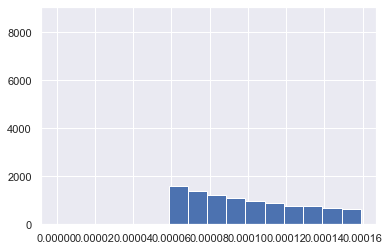

In [114]:
np.histogram(get_convergence_sm())

(array([9696,  200,   61,   21,   10,    4,    4,    2,    0,    2],
       dtype=int64),
 array([2.94531767e-48, 6.62071737e-40, 1.32414347e-39, 1.98621521e-39,
        2.64828694e-39, 3.31035867e-39, 3.97243041e-39, 4.63450214e-39,
        5.29657388e-39, 5.95864561e-39, 6.62071735e-39]))

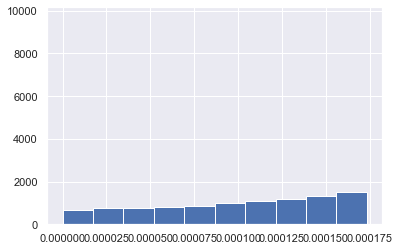

In [115]:
np.histogram(get_convergence_one_exp())

(array([1613., 1310., 1162., 1070., 1012.,  878.,  820.,  747.,  698.,
         690.]),
 array([5.79972633e-05, 6.79627085e-05, 7.79281537e-05, 8.78935989e-05,
        9.78590441e-05, 1.07824489e-04, 1.17789934e-04, 1.27755380e-04,
        1.37720825e-04, 1.47686270e-04, 1.57651715e-04]),
 <BarContainer object of 10 artists>)

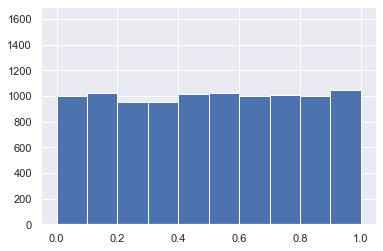

In [90]:
plt.hist(a)
correct_sm = np.exp(a/max(a))
plt.hist(correct/np.sum(correct))

(array([1613., 1310., 1162., 1070., 1012.,  878.,  820.,  747.,  698.,
         690.]),
 array([5.79972633e-05, 6.79627085e-05, 7.79281537e-05, 8.78935989e-05,
        9.78590441e-05, 1.07824489e-04, 1.17789934e-04, 1.27755380e-04,
        1.37720825e-04, 1.47686270e-04, 1.57651715e-04]),
 <BarContainer object of 10 artists>)

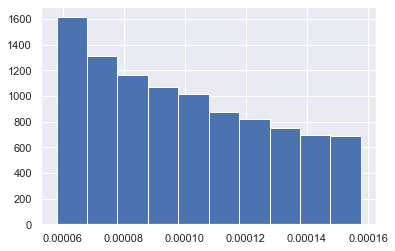

In [91]:
plt.hist(correct_sm/np.sum(correct_sm))

In [135]:
x = ""
eval(x)

SyntaxError: invalid syntax (<string>, line 0)

In [134]:
X.apply(lambda x: f"Tree({x[['mos_light_2', 'mos_middle_1', 'mos_middle_2']].values})", axis=1)

0         Tree([0. 0. 0.])
1         Tree([0. 0. 0.])
2         Tree([0. 0. 0.])
3         Tree([0. 0. 0.])
4         Tree([0. 0. 0.])
                ...       
162913    Tree([0. 0. 0.])
162914    Tree([0. 0. 0.])
162915    Tree([0. 0. 0.])
162916    Tree([0. 0. 0.])
162917    Tree([0. 0. 0.])
Length: 162918, dtype: object

(array([ 655.,  710.,  733.,  790.,  841.,  978., 1081., 1213., 1370.,
        1629.]),
 array([2.04456951e-09, 1.71005277e-05, 3.41990109e-05, 5.12974941e-05,
        6.83959772e-05, 8.54944604e-05, 1.02592944e-04, 1.19691427e-04,
        1.36789910e-04, 1.53888393e-04, 1.70986876e-04]),
 <BarContainer object of 10 artists>)

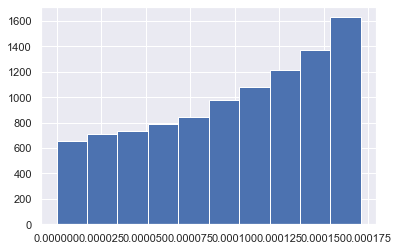

In [92]:
correct_one_sm = 1.0 - np.exp(-a/max(a))
plt.hist(correct_one_sm/np.sum(correct_one_sm))

(array([3980., 1637., 1059.,  771.,  599.,  511.,  405.,  388.,  360.,
         290.]),
 array([1.11686279e-05, 4.52928534e-05, 7.94170789e-05, 1.13541304e-04,
        1.47665530e-04, 1.81789755e-04, 2.15913981e-04, 2.50038206e-04,
        2.84162432e-04, 3.18286657e-04, 3.52410883e-04]),
 <BarContainer object of 10 artists>)

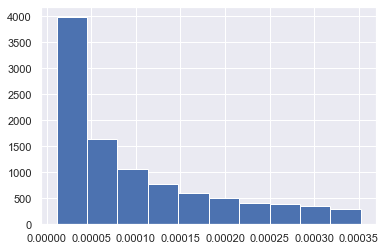

In [122]:
corr = np.exp((a - np.mean(a))/np.std(a))
plt.hist(corr/np.sum(corr))

In [124]:
a 

array([0.83487387, 0.482736  , 0.62094574, ..., 0.35914503, 0.07706707,
       0.96193024])

In [126]:
1/(1+np.exp(-a/max(a)))

array([0.69743765, 0.6184281 , 0.6504762 , ..., 0.58885968, 0.51926304,
       0.72356615])

In [127]:
1.0 - np.exp(-a/max(a))

array([0.56618007, 0.38299715, 0.46266474, ..., 0.30180258, 0.07419376,
       0.61795636])

In [129]:
(a/max(a))**2

array([0.69743499, 0.23317467, 0.38580628, ..., 0.12906299, 0.00594292,
       0.92586817])